## Kernel Thinning and Compress++ using the Sobolev kernel on [0,1]^2

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import time

from goodpoints.jax.kernel.sobol import SobolKernel
from goodpoints.jax.kt import kt
from goodpoints.jax.compress import kt_compresspp
from goodpoints.jax.mmd import compute_mmd

import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
kernel = SobolKernel(2, s=1)

rng_gen = np.random.default_rng(42)
rng = jax.random.PRNGKey(rng_gen.integers(2**31))
q = 18
n = 2**q
m = 2**(q//2)
mean_zero = True
use_compress = True
p = jax.random.uniform(rng, (n, 2))
points = kernel.prepare_input(p)

2024-05-15 12:10:56,435 - INFO - Unable to initialize backend 'cuda': jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE
2024-05-15 12:10:56,437 - INFO - Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
2024-05-15 12:10:56,454 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-05-15 12:10:56,454 - WARNING - CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
K_diag = kernel(points, points)

In [4]:
start_time = time.time()
if use_compress:
    coreset = kt_compresspp(kernel, points, np.ones(n) / n, rng_gen, 
                inflate_size=n, delta=0.5)
else:
    coreset = kt(kernel, points, np.ones(n) / n, 
                n, m, 0.5, rng_gen)
print(f'JAX version took: {time.time() - start_time}s')

2024-05-15 12:10:56,886 - INFO - Compress++ with 262144 points...
2024-05-15 12:10:57,065 - INFO - Compressing to 2^g sqrt(n) points...
2024-05-15 12:11:03,414 - INFO - Kernel thinning to sqrt(n) points...
2024-05-15 12:11:04,866 - INFO - KT-swap improvement...


Elapsed: 11.31851601600647s


In [5]:
from goodpoints.compress import compresspp_kt
start_time = time.time()
coreset_old = compresspp_kt(np.array(p, dtype=float), b'sobolev', 
                            k_params=np.array([1.0]), g=4, mean0=mean_zero)
print(f'Cython version took: {time.time() - start_time}s')

Elapsed: 50.32296633720398s


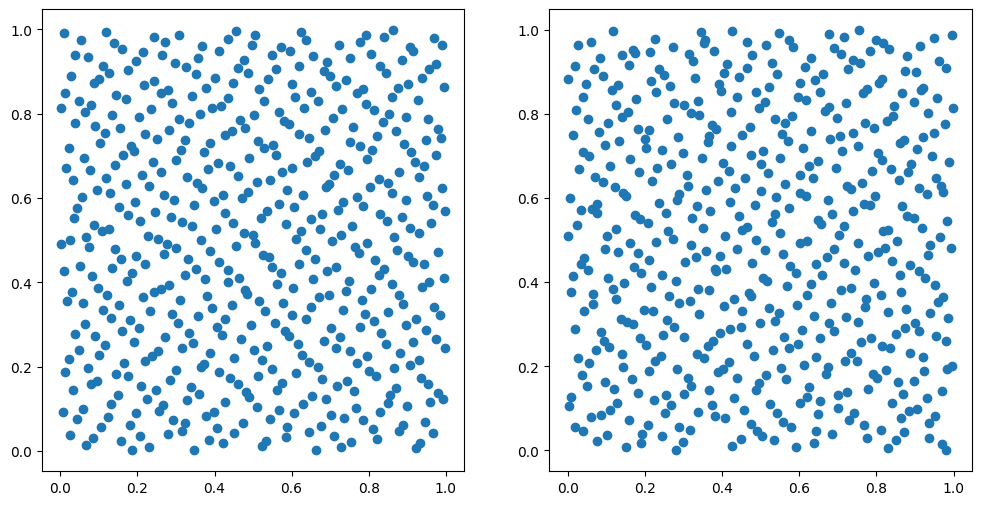

In [6]:
import matplotlib.pyplot as plt

def plot():
    figsize = 6
    fig, axes = plt.subplots(1, 2, figsize=(figsize*2,figsize))
    axes[0].scatter(p[coreset, 0], p[coreset, 1])
    axes[1].scatter(p[coreset_old, 0], p[coreset_old, 1])

plot()

In [9]:
for i, cur_coreset in enumerate([coreset, coreset_old]):
    mmd_input = compute_mmd(kernel, points.subset(cur_coreset),
                            points2=points, mode='full')
    mmd_P = compute_mmd(kernel, points.subset(cur_coreset), mode='mean-zero')
    ver = 'JAX' if i == 0 else 'Cython'
    print(f'[{ver} version] MMD to input points: {mmd_input}, MMD to P: {mmd_P}')

[JAX version] MMD to input points: 0.0012039425782859325, MMD to P: 0.0011680572060868144
[Cython version] MMD to input points: 0.001657873741351068, MMD to P: 0.001615745946764946
